In [1]:
import cv2
import json
import openvino as ov
import numpy as np
import matplotlib.pyplot as plt

core = ov.Core()

## Extract and Transform

In [36]:
def extractFrames(path): 
    images = []
    # Path to video file 
    vidObj = cv2.VideoCapture(path) 
  
    # Used as counter variable 
    count = 0
  
    # checks whether frames were extracted 
    success = 1
  
    while success: 
        success, image = vidObj.read() 
        images.append(image)
        count += 1
    return images

In [94]:
video_input_path = './data/ccdfec32-b738be17.mp4'

In [95]:
video_output_path = './segmented_ccdfec32-b738be17-every2frames.mp4'

In [96]:
images=extractFrames(video_input_path)

In [97]:
len(images)

1212

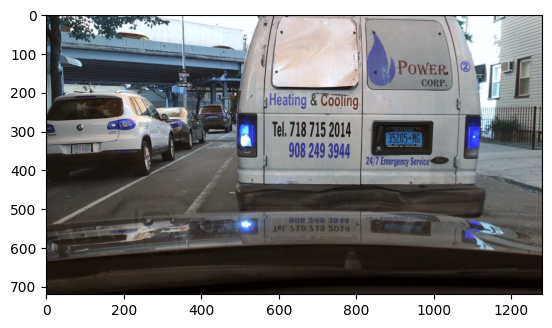

In [98]:
plt.imshow(images[1210])

In [83]:
def partition_list(lst, max_size):
    """
    Partitions a list into smaller lists with a maximum size.
    
    Args:
        lst (list): The list to be partitioned.
        max_size (int): The maximum size of each partitioned list.
        
    Returns:
        list: A list of lists, where each inner list has a maximum size of `max_size`.
    """
    partitioned_list = []
    for i in range(0, len(lst), max_size):
        partitioned_list.append(lst[i:i+max_size])
    return partitioned_list


In [99]:
second_list = partition_list(images, 2)

In [100]:
len(second_list[-1])

2

In [101]:
second_list[-1].pop()

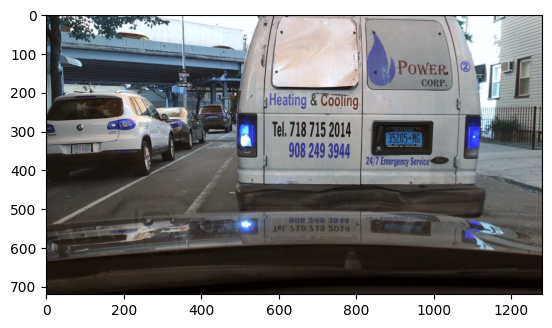

In [102]:
plt.imshow(second_list[-1][-1])

In [44]:
def resize(mask, height, width):
    # Resize the array to match the height of the target shape (1280, 720)
    resized_array = cv2.resize(mask, (width, height), interpolation=cv2.INTER_LINEAR)
    return resized_array

def load_model(model_dir):
    model = core.read_model(model=model_dir)
    compiled_model = core.compile_model(model=model, device_name='CPU')
    input_layer_ir = compiled_model.input(0)
    output_layer_ir = compiled_model.output(0)
    N, C, H, W = input_layer_ir.shape
    return compiled_model, H, W, output_layer_ir

def preprocess(frame, H, W):
    """
    Preprocess the frame for openvino model.
    """
    image_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    resized_image = cv2.resize(image_bgr, (W, H))
    # Reshape to the network input shape.
    input_image = np.expand_dims(
        resized_image.transpose(2, 0, 1), 0
    )  
    return input_image

def postprocess(frame, model_result, height, width, alpha = 0.3):
    """
    Postprocess the frame for visualization.
    """
    # Constants
    colormap = np.array([[0, 0, 0], [119, 255, 51], [120, 183, 53], [86, 210, 245]])
    # Divide the mask into four equal parts along the first axis
    parts = np.split(model_result, 4, axis=1)
    # Select the road mask and curbs parts
    bg = parts[0].reshape((512,896,1))
    road = parts[1].reshape((512,896,1))
    marks = parts[2].reshape((512,896,1))
    curbs = parts[3].reshape((512,896,1))
    # Rescale the values to the range [0, 255]
    bg_white_mask = bg * [255, 255, 255]
    road_white_mask = road * [255, 255, 255]
    curbs_white_mask = curbs * [255, 255, 255]
    marks_white_mask = marks * [255, 255, 255]
    road_colored_mask = road * colormap[1]
    marks_colored_mask = marks * colormap[2]
    curbs_colored_mask = curbs * colormap[3]
    # Change type of np array to avoid errors later
    bg_white_mask = bg_white_mask.astype('uint8')
    road_colored_mask = road_colored_mask.astype('uint8')
    marks_colored_mask = marks_colored_mask.astype('uint8')
    curbs_colored_mask = curbs_colored_mask.astype('uint8')
    road_white_mask = road_white_mask.astype('uint8')
    marks_white_mask = marks_white_mask.astype('uint8')
    curbs_white_mask= curbs_white_mask.astype('uint8')
    # Resize to original image width and height
    bg_white_mask = resize(bg_white_mask, height, width)
    road_white_mask = resize(road_white_mask, height, width)
    marks_white_mask = resize(marks_white_mask, height, width)
    curbs_white_mask= resize(curbs_white_mask, height, width)
    road_colored_mask = resize(road_colored_mask, height, width)
    marks_colored_mask = resize(road_colored_mask, height, width)
    curbs_colored_mask = resize(curbs_colored_mask, height, width)
    # Image Arthimatic Operations
    colored_mask = road_colored_mask + curbs_colored_mask
    white_mask = road_white_mask + curbs_white_mask + marks_white_mask
    # Bitwise Operations
    subtracted_road=cv2.bitwise_and(frame, bg_white_mask,mask=None)
    segmented_road=cv2.bitwise_and(frame, white_mask,mask=None)
    # Overlay
    alpha = .7
    overlay = segmented_road.copy()
    segmented_image = cv2.addWeighted(colored_mask, alpha, overlay, 1-alpha, 0, overlay)
    final_result=cv2.bitwise_or(subtracted_road,segmented_image,mask=None)

    return final_result

In [104]:
model_name = "models/road-segmentation-adas-0001"

In [105]:
compiled_model, H, W, output_layer_ir = load_model(model_name)

In [106]:
image_h, image_w, _ = images[0].shape

In [108]:
# Define codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = None
for iIdx, i in enumerate(second_list):
    frame = i[0]
    input_image = preprocess(frame, H, W)

    # Perform inference
    result = compiled_model([input_image])[output_layer_ir]

    # Post-processing steps here...
    bg_white_mask, white_mask, colored_mask = postprocess_road_segmentation(frame, result, image_h, image_w)
    for jIdx, j in enumerate(i):
        # Bitwise Operations
        subtracted_road=cv2.bitwise_and(j, bg_white_mask,mask=None)
        segmented_road=cv2.bitwise_and(j, white_mask,mask=None)
        # Overlay
        alpha = .7
        overlay = segmented_road.copy()
        segmented_image = cv2.addWeighted(colored_mask, alpha, overlay, 1-alpha, 0, overlay)
        final_result=cv2.bitwise_or(subtracted_road,segmented_image,mask=None)
        
        if out is None:
            out = cv2.VideoWriter(video_output_path, fourcc, 20.0, (image_w, image_h))

        out.write(final_result)  # Write the frame or the processed frame
        print(f'frame {jIdx} written in list {iIdx}')
out.release()

frame 0 written in list 0
frame 1 written in list 0
frame 0 written in list 1
frame 1 written in list 1
frame 0 written in list 2
frame 1 written in list 2
frame 0 written in list 3
frame 1 written in list 3
frame 0 written in list 4
frame 1 written in list 4
frame 0 written in list 5
frame 1 written in list 5
frame 0 written in list 6
frame 1 written in list 6
frame 0 written in list 7
frame 1 written in list 7
frame 0 written in list 8
frame 1 written in list 8
frame 0 written in list 9
frame 1 written in list 9
frame 0 written in list 10
frame 1 written in list 10
frame 0 written in list 11
frame 1 written in list 11
frame 0 written in list 12
frame 1 written in list 12
frame 0 written in list 13
frame 1 written in list 13
frame 0 written in list 14
frame 1 written in list 14
frame 0 written in list 15
frame 1 written in list 15
frame 0 written in list 16
frame 1 written in list 16
frame 0 written in list 17
frame 1 written in list 17
frame 0 written in list 18
frame 1 written in li